# 📘 Model Evaluation Notebook — AquaSafe

**Notebook:** `05_model_evaluation.ipynb`

**Input:** Trained models from `models/` directory, test data from `data/processed/`

**Output:** Comprehensive evaluation report and visualizations

---

## 🎯 Objective

Perform detailed evaluation and interpretation of trained models:
- Load saved models and evaluate on test set
- Analyze per-class performance and failure modes
- Interpret feature importance with domain context
- Analyze prediction confidence
- Document limitations and recommendations

---
## Section 1: Imports

In [1]:
import pandas as pd
import numpy as np
import os
import joblib
from pathlib import Path

from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, precision_recall_curve
)
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt
import seaborn as sns

from utils.config import DATA_DIR
from src.data_preprocessing.create_dataframe import create_dataframe

plt.rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")

print("✓ All imports successful")

✓ All imports successful


---
## Section 2: Load Artifacts

In [2]:
MODELS_DIR = Path(DATA_DIR).parent / "models"

# Load best model name
best_model_name = (MODELS_DIR / "best_model_name.txt").read_text().strip()
print(f"✓ Best model: {best_model_name}")

# Load best model
model = joblib.load(MODELS_DIR / f"{best_model_name.lower()}_pipeline.pkl")
print(f"✓ Model loaded")

# Load label encoder
label_encoder = joblib.load(MODELS_DIR / "label_encoder.pkl")
print(f"✓ Label encoder loaded: {label_encoder.classes_}")

# Load feature names
feature_names = joblib.load(MODELS_DIR / "feature_names.pkl")
print(f"✓ Feature names loaded: {len(feature_names)} features")

✓ Best model: LogisticRegression
✓ Model loaded
✓ Label encoder loaded: ['A' 'B' 'C' 'E']
✓ Feature names loaded: 92 features


In [3]:
# Load test data
TEST_PATH = os.path.join(DATA_DIR, "processed", "csv", "test.csv")
test_df = create_dataframe(TEST_PATH)

TARGET_COL = "use_based_class"

X_test = test_df.drop(columns=[TARGET_COL])
y_test = test_df[TARGET_COL].values

print(f"\n✓ Test data loaded: {X_test.shape}")


✓ Test data loaded: (35, 92)


---
## Section 3: Model Predictions

In [4]:
# Generate predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

print(f"✓ Predictions generated")
print(f"   Samples: {len(y_pred)}")
print(f"   Classes: {np.unique(y_pred)}")

✓ Predictions generated
   Samples: 35
   Classes: [0 1 2 3]


---
## Section 4: Performance Metrics

In [5]:
# Calculate metrics
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "F1 (Macro)": f1_score(y_test, y_pred, average='macro', zero_division=0),
    "Precision (Macro)": precision_score(y_test, y_pred, average='macro', zero_division=0),
    "Recall (Macro)": recall_score(y_test, y_pred, average='macro', zero_division=0),
    "F1 (Weighted)": f1_score(y_test, y_pred, average='weighted', zero_division=0),
}

print("\n" + "="*60)
print(f"📊 {best_model_name} - TEST SET PERFORMANCE")
print("="*60)

for metric, value in metrics.items():
    print(f"   {metric:.<30} {value:.4f}")

print("="*60)


📊 LogisticRegression - TEST SET PERFORMANCE
   Accuracy...................... 0.9429
   F1 (Macro).................... 0.9083
   Precision (Macro)............. 0.9839
   Recall (Macro)................ 0.8750
   F1 (Weighted)................. 0.9343


In [6]:
# Detailed classification report
print("\n" + "="*60)
print("📋 CLASSIFICATION REPORT")
print("="*60)

print(classification_report(
    y_test, y_pred,
    target_names=[str(c) for c in label_encoder.classes_],
    digits=4,
    zero_division=0
))


📋 CLASSIFICATION REPORT
              precision    recall  f1-score   support

           A     0.9355    1.0000    0.9667        29
           B     1.0000    1.0000    1.0000         1
           C     1.0000    1.0000    1.0000         1
           E     1.0000    0.5000    0.6667         4

    accuracy                         0.9429        35
   macro avg     0.9839    0.8750    0.9083        35
weighted avg     0.9465    0.9429    0.9343        35



---
## Section 5: Confusion Matrix

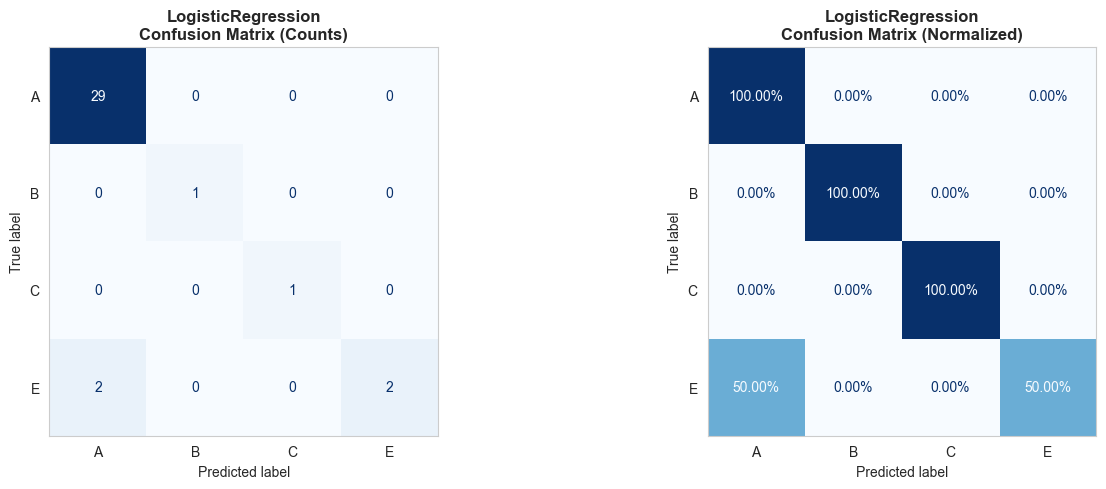


💡 Interpretation:
   • Diagonal: Correct predictions
   • Off-diagonal: Misclassifications
   • Normalized shows recall per class


In [7]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw counts
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp1.plot(ax=axes[0], cmap='Blues', values_format='d', colorbar=False)
axes[0].set_title(f'{best_model_name}\nConfusion Matrix (Counts)', fontweight='bold')
axes[0].grid(False)

# Normalized (percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=label_encoder.classes_)
disp2.plot(ax=axes[1], cmap='Blues', values_format='.2%', colorbar=False)
axes[1].set_title(f'{best_model_name}\nConfusion Matrix (Normalized)', fontweight='bold')
axes[1].grid(False)

plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("   • Diagonal: Correct predictions")
print("   • Off-diagonal: Misclassifications")
print("   • Normalized shows recall per class")

---
## Section 6: Per-Class Analysis

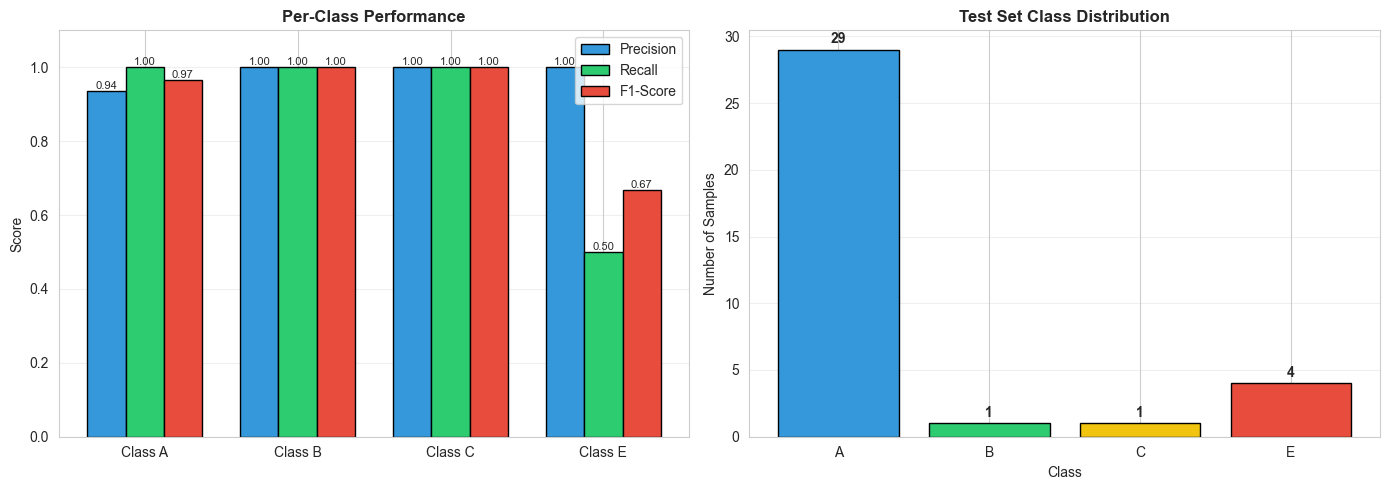

In [8]:
# Per-class metrics
report_dict = classification_report(
    y_test, y_pred,
    target_names=[str(c) for c in label_encoder.classes_],
    output_dict=True,
    zero_division=0
)

classes = [str(c) for c in label_encoder.classes_]
precision_scores = [report_dict[c]['precision'] for c in classes]
recall_scores = [report_dict[c]['recall'] for c in classes]
f1_scores = [report_dict[c]['f1-score'] for c in classes]
support = [report_dict[c]['support'] for c in classes]

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Per-class metrics bar chart
x = np.arange(len(classes))
width = 0.25

bars1 = axes[0].bar(x - width, precision_scores, width, label='Precision', color='#3498db', edgecolor='black')
bars2 = axes[0].bar(x, recall_scores, width, label='Recall', color='#2ecc71', edgecolor='black')
bars3 = axes[0].bar(x + width, f1_scores, width, label='F1-Score', color='#e74c3c', edgecolor='black')

axes[0].set_ylabel('Score')
axes[0].set_title('Per-Class Performance', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels([f'Class {c}' for c in classes])
axes[0].legend()
axes[0].set_ylim(0, 1.1)
axes[0].grid(axis='y', alpha=0.3)

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                    f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=8)

# Support distribution
colors = ['#3498db', '#2ecc71', '#f1c40f', '#e74c3c']
axes[1].bar(classes, support, color=colors[:len(classes)], edgecolor='black')
axes[1].set_ylabel('Number of Samples')
axes[1].set_title('Test Set Class Distribution', fontweight='bold')
axes[1].set_xlabel('Class')
axes[1].grid(axis='y', alpha=0.3)

for i, v in enumerate(support):
    axes[1].text(i, v + 0.5, str(int(v)), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [9]:
# Class performance summary
print("\n" + "="*60)
print("📊 PER-CLASS PERFORMANCE SUMMARY")
print("="*60)

print("\n   Class | Precision | Recall | F1-Score | Support | Status")
print("   " + "-"*60)

for i, cls in enumerate(classes):
    p = precision_scores[i]
    r = recall_scores[i]
    f1 = f1_scores[i]
    sup = support[i]
    
    if f1 >= 0.8:
        status = "✓ Excellent"
    elif f1 >= 0.7:
        status = "✓ Good"
    elif f1 >= 0.5:
        status = "⚠️ Fair"
    else:
        status = "❌ Poor"
    
    print(f"     {cls}   |   {p:.3f}   |  {r:.3f} |   {f1:.3f}  |   {int(sup):3d}   | {status}")

print("   " + "-"*60)


📊 PER-CLASS PERFORMANCE SUMMARY

   Class | Precision | Recall | F1-Score | Support | Status
   ------------------------------------------------------------
     A   |   0.935   |  1.000 |   0.967  |    29   | ✓ Excellent
     B   |   1.000   |  1.000 |   1.000  |     1   | ✓ Excellent
     C   |   1.000   |  1.000 |   1.000  |     1   | ✓ Excellent
     E   |   1.000   |  0.500 |   0.667  |     4   | ⚠️ Fair
   ------------------------------------------------------------


---
## Section 7: Prediction Confidence Analysis

/var/folders/6v/hkbk037d3pzdzhlx0pny88fw0000gn/T/ipykernel_29512/178797792.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[2].boxplot(confidence_data, labels=['Correct', 'Incorrect'], patch_artist=True)


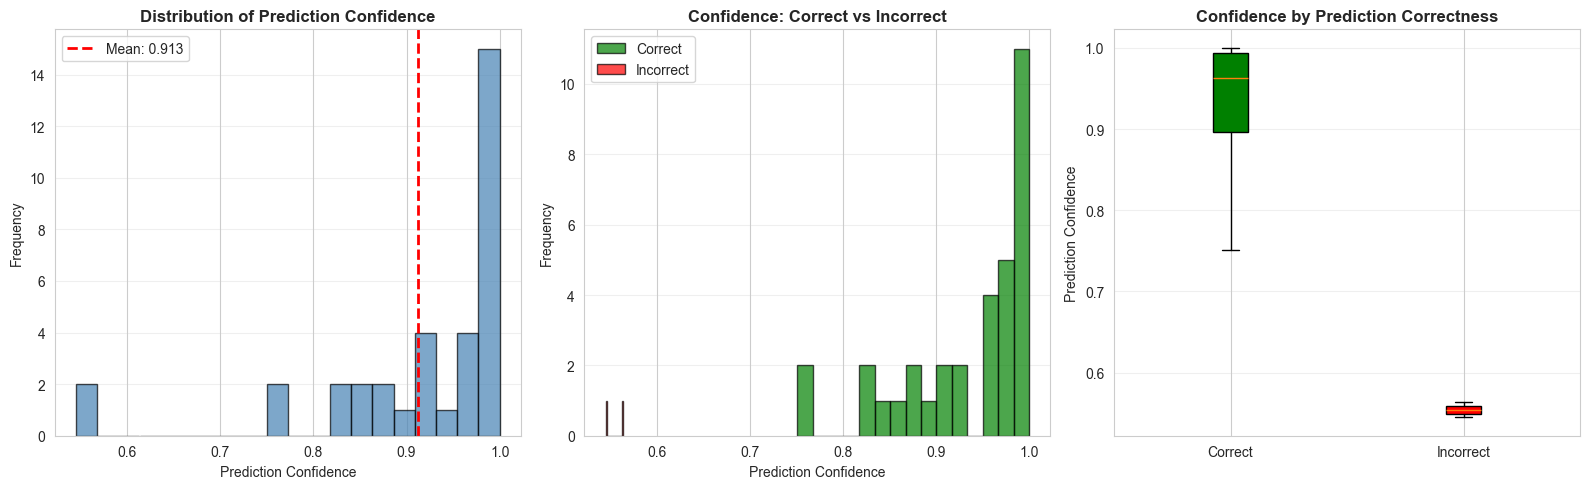


📊 Confidence Statistics:
   Overall mean confidence: 0.9128
   Correct predictions mean: 0.9346
   Incorrect predictions mean: 0.5542


In [10]:
# Prediction confidence
max_proba = np.max(y_pred_proba, axis=1)
correct_mask = y_pred == y_test

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Distribution of confidence scores
axes[0].hist(max_proba, bins=20, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(np.mean(max_proba), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(max_proba):.3f}')
axes[0].set_xlabel('Prediction Confidence')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Prediction Confidence', fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Confidence: Correct vs Incorrect
axes[1].hist(max_proba[correct_mask], bins=15, alpha=0.7, label='Correct', color='green', edgecolor='black')
axes[1].hist(max_proba[~correct_mask], bins=15, alpha=0.7, label='Incorrect', color='red', edgecolor='black')
axes[1].set_xlabel('Prediction Confidence')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Confidence: Correct vs Incorrect', fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# Box plot by correctness
confidence_data = [max_proba[correct_mask], max_proba[~correct_mask]]
bp = axes[2].boxplot(confidence_data, labels=['Correct', 'Incorrect'], patch_artist=True)
bp['boxes'][0].set_facecolor('green')
bp['boxes'][1].set_facecolor('red')
axes[2].set_ylabel('Prediction Confidence')
axes[2].set_title('Confidence by Prediction Correctness', fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Confidence Statistics:")
print(f"   Overall mean confidence: {np.mean(max_proba):.4f}")
print(f"   Correct predictions mean: {np.mean(max_proba[correct_mask]):.4f}")
print(f"   Incorrect predictions mean: {np.mean(max_proba[~correct_mask]):.4f}" if sum(~correct_mask) > 0 else "   No incorrect predictions")

---
## Section 8: Misclassification Analysis

In [11]:
# Find misclassified samples
misclassified_idx = np.where(y_pred != y_test)[0]

print("\n" + "="*60)
print("🔍 MISCLASSIFICATION ANALYSIS")
print("="*60)

print(f"\n   Total test samples: {len(y_test)}")
print(f"   Correctly classified: {sum(correct_mask)} ({sum(correct_mask)/len(y_test)*100:.1f}%)")
print(f"   Misclassified: {len(misclassified_idx)} ({len(misclassified_idx)/len(y_test)*100:.1f}%)")

if len(misclassified_idx) > 0:
    print(f"\n   Misclassification Details (showing up to 10):")
    print("   " + "-"*55)
    print("   Index | Actual | Predicted | Confidence")
    print("   " + "-"*55)
    
    for idx in misclassified_idx[:10]:
        actual = label_encoder.inverse_transform([y_test[idx]])[0]
        predicted = label_encoder.inverse_transform([y_pred[idx]])[0]
        confidence = max_proba[idx]
        print(f"   {idx:5d} |   {actual}    |     {predicted}     |   {confidence:.4f}")
    
    if len(misclassified_idx) > 10:
        print(f"   ... and {len(misclassified_idx) - 10} more")
else:
    print("\n   ✓ No misclassifications!")


🔍 MISCLASSIFICATION ANALYSIS

   Total test samples: 35
   Correctly classified: 33 (94.3%)
   Misclassified: 2 (5.7%)

   Misclassification Details (showing up to 10):
   -------------------------------------------------------
   Index | Actual | Predicted | Confidence
   -------------------------------------------------------
      21 |   E    |     A     |   0.5450
      28 |   E    |     A     |   0.5634


In [12]:
# Misclassification patterns
if len(misclassified_idx) > 0:
    print("\n📊 Misclassification Patterns:")
    print("   (Actual → Predicted: Count)")
    print("   " + "-"*30)
    
    misclass_pairs = {}
    for idx in misclassified_idx:
        actual = label_encoder.inverse_transform([y_test[idx]])[0]
        predicted = label_encoder.inverse_transform([y_pred[idx]])[0]
        key = f"{actual} → {predicted}"
        misclass_pairs[key] = misclass_pairs.get(key, 0) + 1
    
    for pair, count in sorted(misclass_pairs.items(), key=lambda x: x[1], reverse=True):
        print(f"   {pair}: {count}")


📊 Misclassification Patterns:
   (Actual → Predicted: Count)
   ------------------------------
   E → A: 2


---
## Section 9: Feature Importance


📊 FEATURE IMPORTANCE (LogisticRegression)


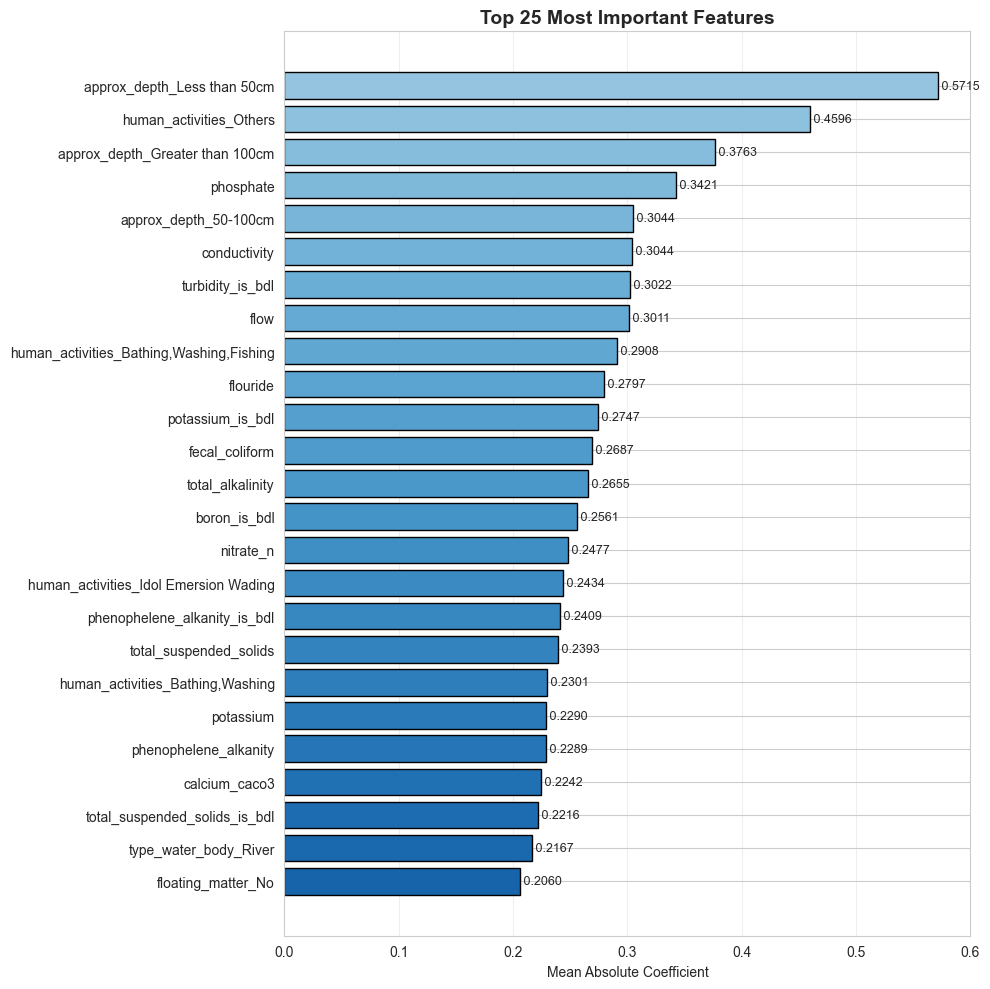


🔍 Top 10 Features:
                                 Feature  Importance
             approx_depth_Less than 50cm    0.571472
                 human_activities_Others    0.459565
         approx_depth_Greater than 100cm    0.376294
                               phosphate    0.342131
                   approx_depth_50-100cm    0.304442
                            conductivity    0.304393
                        turbidity_is_bdl    0.302214
                                    flow    0.301104
human_activities_Bathing,Washing,Fishing    0.290774
                                flouride    0.279738


In [13]:
# Feature importance based on model type
print("\n" + "="*60)
print(f"📊 FEATURE IMPORTANCE ({best_model_name})")
print("="*60)

# Get the actual model from pipeline
actual_model = model.named_steps['model']

# Check model type and extract importance
if hasattr(actual_model, 'feature_importances_'):
    # Tree-based models
    importances = actual_model.feature_importances_
    importance_type = "Feature Importance"
elif hasattr(actual_model, 'coef_'):
    # Linear models - use mean absolute coefficient across classes
    importances = np.mean(np.abs(actual_model.coef_), axis=0)
    importance_type = "Mean Absolute Coefficient"
else:
    importances = None
    print("   Cannot extract feature importance for this model type")

if importances is not None:
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 10))
    
    top_n = min(25, len(importance_df))
    top_features = importance_df.head(top_n)
    
    colors = plt.cm.Blues(np.linspace(0.4, 0.8, top_n))
    bars = ax.barh(range(top_n), top_features['Importance'].values, color=colors, edgecolor='black')
    ax.set_yticks(range(top_n))
    ax.set_yticklabels(top_features['Feature'].values)
    ax.invert_yaxis()
    ax.set_xlabel(importance_type)
    ax.set_title(f'Top {top_n} Most Important Features', fontweight='bold', fontsize=14)
    ax.grid(axis='x', alpha=0.3)
    
    for i, bar in enumerate(bars):
        ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2.,
               f' {bar.get_width():.4f}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n🔍 Top 10 Features:")
    print(importance_df.head(10).to_string(index=False))

---
## Section 10: Model Comparison (All Models)

In [14]:
# Load and evaluate all models
model_names = ['LogisticRegression', 'RandomForest', 'XGBoost']
all_results = {}

print("\n" + "="*60)
print("📊 ALL MODELS COMPARISON")
print("="*60)

for name in model_names:
    model_path = MODELS_DIR / f"{name.lower()}_pipeline.pkl"
    if model_path.exists():
        loaded_model = joblib.load(model_path)
        pred = loaded_model.predict(X_test)
        
        all_results[name] = {
            'accuracy': accuracy_score(y_test, pred),
            'f1_macro': f1_score(y_test, pred, average='macro', zero_division=0),
            'precision_macro': precision_score(y_test, pred, average='macro', zero_division=0),
            'recall_macro': recall_score(y_test, pred, average='macro', zero_division=0)
        }

# Create comparison dataframe
comparison_df = pd.DataFrame(all_results).T
comparison_df.columns = ['Accuracy', 'F1 (Macro)', 'Precision', 'Recall']
print("\n" + comparison_df.round(4).to_string())

# Highlight best
print(f"\n🏆 Best Model: {best_model_name}")


📊 ALL MODELS COMPARISON

                    Accuracy  F1 (Macro)  Precision  Recall
LogisticRegression    0.9429      0.9083     0.9839  0.8750
RandomForest          0.8571      0.4802     0.4632  0.5000
XGBoost               0.9143      0.7583     0.8589  0.8125

🏆 Best Model: LogisticRegression


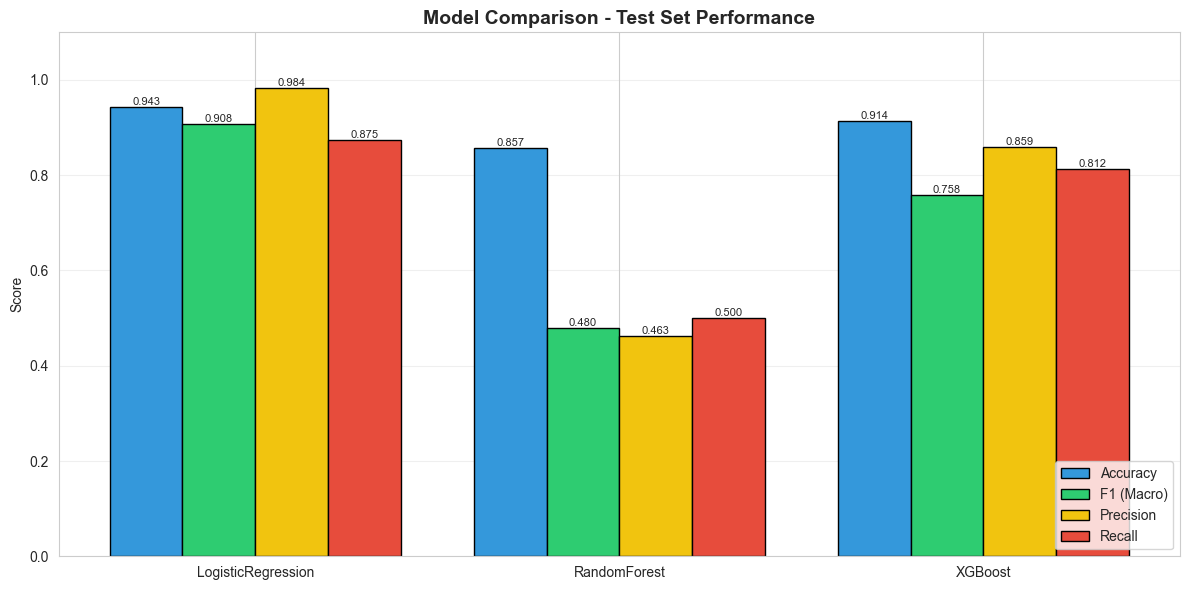

In [15]:
# Visual comparison
if len(all_results) > 1:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(all_results))
    width = 0.2
    
    metrics_to_plot = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']
    colors = ['#3498db', '#2ecc71', '#f1c40f', '#e74c3c']
    labels = ['Accuracy', 'F1 (Macro)', 'Precision', 'Recall']
    
    for i, (metric, color, label) in enumerate(zip(metrics_to_plot, colors, labels)):
        values = [all_results[name][metric] for name in all_results.keys()]
        bars = ax.bar(x + i*width, values, width, label=label, color=color, edgecolor='black')
        
        for bar in bars:
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                   f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=8)
    
    ax.set_ylabel('Score')
    ax.set_title('Model Comparison - Test Set Performance', fontweight='bold', fontsize=14)
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels(list(all_results.keys()))
    ax.legend(loc='lower right')
    ax.set_ylim(0, 1.1)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

---
## Section 11: Summary & Recommendations

In [16]:
print("\n" + "="*80)
print("📋 EVALUATION SUMMARY")
print("="*80)

print(f"""
MODEL PERFORMANCE:
------------------
• Best Model: {best_model_name}
• Test Accuracy: {metrics['Accuracy']:.4f}
• Test F1 (Macro): {metrics['F1 (Macro)']:.4f}
• Test Precision: {metrics['Precision (Macro)']:.4f}
• Test Recall: {metrics['Recall (Macro)']:.4f}

PER-CLASS SUMMARY:
------------------""")

for i, cls in enumerate(classes):
    status = "✓" if f1_scores[i] >= 0.7 else "⚠️" if f1_scores[i] >= 0.5 else "❌"
    print(f"• Class {cls}: F1={f1_scores[i]:.3f} {status}")

print(f"""
PREDICTION CONFIDENCE:
----------------------
• Mean confidence: {np.mean(max_proba):.4f}
• Correct predictions confidence: {np.mean(max_proba[correct_mask]):.4f}
• Misclassified samples: {len(misclassified_idx)} ({len(misclassified_idx)/len(y_test)*100:.1f}%)
""")


📋 EVALUATION SUMMARY

MODEL PERFORMANCE:
------------------
• Best Model: LogisticRegression
• Test Accuracy: 0.9429
• Test F1 (Macro): 0.9083
• Test Precision: 0.9839
• Test Recall: 0.8750

PER-CLASS SUMMARY:
------------------
• Class A: F1=0.967 ✓
• Class B: F1=1.000 ✓
• Class C: F1=1.000 ✓
• Class E: F1=0.667 ⚠️

PREDICTION CONFIDENCE:
----------------------
• Mean confidence: 0.9128
• Correct predictions confidence: 0.9346
• Misclassified samples: 2 (5.7%)



In [17]:
print("\n" + "="*80)
print("💡 RECOMMENDATIONS")
print("="*80)

recommendations = []

# Check for weak classes
weak_classes = [cls for cls, f1 in zip(classes, f1_scores) if f1 < 0.7]
if weak_classes:
    recommendations.append(f"• Improve performance on weak classes: {weak_classes}")
    recommendations.append("  → Consider collecting more samples for these classes")
    recommendations.append("  → Try class-specific feature engineering")

# Check confidence
if np.mean(max_proba) < 0.7:
    recommendations.append("• Model shows low confidence in predictions")
    recommendations.append("  → Consider model calibration techniques")

# General recommendations
recommendations.append("• Consider hyperparameter tuning (GridSearchCV, Optuna)")
recommendations.append("• Try ensemble methods (stacking, voting)")
recommendations.append("• Add SHAP values for better interpretability")
recommendations.append("• Monitor model performance in production")

for rec in recommendations:
    print(rec)

print("\n" + "="*80)
print("✅ EVALUATION COMPLETE")
print("="*80)


💡 RECOMMENDATIONS
• Improve performance on weak classes: ['E']
  → Consider collecting more samples for these classes
  → Try class-specific feature engineering
• Consider hyperparameter tuning (GridSearchCV, Optuna)
• Try ensemble methods (stacking, voting)
• Add SHAP values for better interpretability
• Monitor model performance in production

✅ EVALUATION COMPLETE
